In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

In [3]:

# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
            #print(mapper)
    #print(mapper)
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        #print(v)
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
            #print(v)
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
   # print(df_ext[result_column_name])
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
path='C:/Users/yashk/Desktop/ADM/Assignment/Assignmnet _2/criteo_attribution_dataset/pcb_dataset_final.tsv'
df0 = pd.read_csv(path, sep='\t')

n_campaigns = 400

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])
df6

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
531222,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,22644417,9312274,21091111,24607497_-1,7.487274e-07,0.163526,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
565284,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,11409684,26597096,4480345,29196072,29196072,25357769_-1,1.123091e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
407838,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,5824237,1973606,9180723,29841067,29196072,7306395_3063962,1.123091e-06,0.000000,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49965,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,32440044,1973606,2687461,29841067,21091108,93907_-1,1.497455e-06,0.101299,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
551556,10,28435820,21640043,0,-1,-1,0,1,-1,-1,...,11409686,1973606,20921639,3225256,8661623,28435820_-1,3.743637e-06,0.202055,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553187,2671162,12508139,3828360,1,4887281,17799400,0,1,1,2,...,5824235,32440053,27941791,29196072,21091108,12508139_17799400,9.999861e-01,0.086330,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
438733,2671166,477683,32368244,1,3084323,18913526,0,1,1,4,...,11409684,26597099,16407721,29196072,29520626,477683_18913526,9.999876e-01,0.047933,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
368903,2671175,12769977,6686704,0,-1,-1,0,1,-1,-1,...,32440044,1973606,11871047,3225256,29196072,12769977_-1,9.999910e-01,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
429454,2671176,19065515,8980584,1,4656976,24966585,0,1,4,7,...,11409686,1973606,2624617,26597096,21091111,19065515_24966585,9.999914e-01,0.168348,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
#df6['uid'].nunique()
df6.groupby('uid')['uid'].count().sort_values( ascending=False)

uid
8826511     880
29262375    323
22313205    282
14886238    236
31020079    234
           ... 
21407957      2
9448914       2
21408847      2
9448714       2
32458592      2
Name: uid, Length: 112865, dtype: int64

In [27]:
df_x=pd.DataFrame(data=None)
df_x['a']=[1,2,3,4,5]
df_x['b']=[6,7,8,9,10]

#df_ext[result_column_name] = df_ext[column_names].values.tolist()

df_x['a'].iloc[3]

4

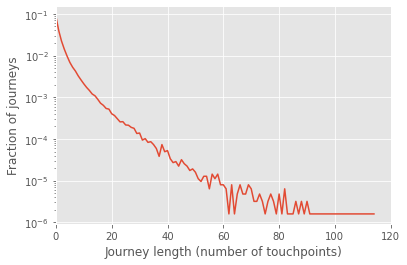

In [97]:
def journey_lenght_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_lenght_histogram(df4)

plt.plot(range(len(hist_y)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

In [6]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
           # print(str(campaign_one_hot))
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    #print(campaign_impressions)
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
    #print(campaign_conversions)  
    return campaign_conversions / campaign_impressions
 
lta = last_touch_attribution(df6)
lta

array([0.04002785, 0.15729938, 0.0394798 , 0.11898197, 0.2543924 ,
       0.10596026, 0.02814815, 0.10029499, 0.10796767, 0.0831392 ,
       0.10998043, 0.28313831, 0.1125148 , 0.07218935, 0.17618469,
       0.09583859, 0.03486529, 0.1969697 , 0.07513111, 0.15018035,
       0.10347944, 0.08258999, 0.10734463, 0.10023842, 0.1071093 ,
       0.24199288, 0.05426357, 0.066313  , 0.17769251, 0.11796675,
       0.05102041, 0.17805519, 0.06858238, 0.09090909, 0.17404012,
       0.10007665, 0.15913978, 0.23209584, 0.15342163, 0.21428571,
       0.03296703, 0.01574803, 0.265286  , 0.06018137, 0.09309309,
       0.17013261, 0.02622577, 0.03861004, 0.03824092, 0.08035714,
       0.0973822 , 0.20103093, 0.1502575 , 0.17574692, 0.14068599,
       0.16922095, 0.20540691, 0.1799591 , 0.14909478, 0.09210526,
       0.10763622, 0.08156607, 0.3358043 , 0.09136213, 0.3156708 ,
       0.04100946, 0.10271194, 0.17073171, 0.15530253, 0.05977695,
       0.04946996, 0.06782398, 0.16176471, 0.05517241, 0.14195

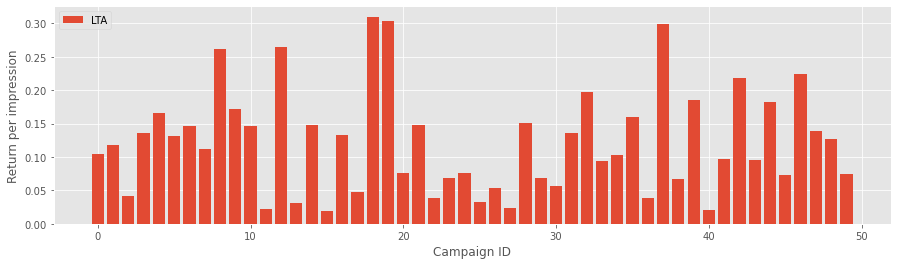

In [7]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [8]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [9]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(132381, 1603)


In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [11]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8709068247913283


C:\Users\yashk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])


Epoch 1/10
662/662 [==============================] - 4s 4ms/step - loss: 0.5759 - accuracy: 0.7297 - val_loss: 0.4584 - val_accuracy: 0.8121
Epoch 2/10
662/662 [==============================] - 2s 3ms/step - loss: 0.4459 - accuracy: 0.8185 - val_loss: 0.4259 - val_accuracy: 0.8238
Epoch 3/10
662/662 [==============================] - 2s 3ms/step - loss: 0.4131 - accuracy: 0.8334 - val_loss: 0.4077 - val_accuracy: 0.8349
Epoch 4/10
662/662 [==============================] - 2s 3ms/step - loss: 0.4031 - accuracy: 0.8390 - val_loss: 0.3963 - val_accuracy: 0.8400
Epoch 5/10
662/662 [==============================] - 2s 3ms/step - loss: 0.3881 - accuracy: 0.8454 - val_loss: 0.3880 - val_accuracy: 0.8419
Epoch 6/10
662/662 [==============================] - 2s 3ms/step - loss: 0.3814 - accuracy: 0.8470 - val_loss: 0.3817 - val_accuracy: 0.8445
Epoch 7/10
662/662 [==============================] - 2s 3ms/step - loss: 0.3698 - accuracy: 0.8549 - val_loss: 0.3766 - val_accuracy: 0.8461
Epoch 

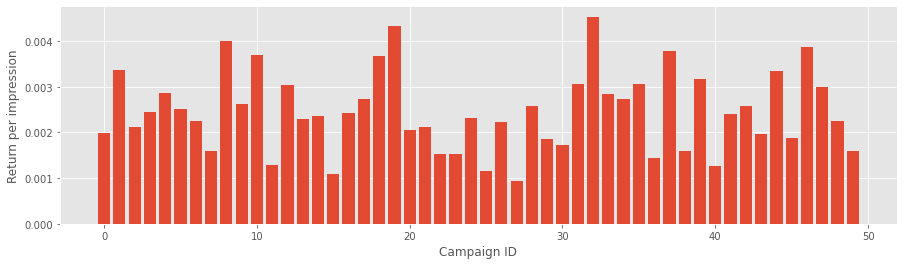

In [13]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

In [14]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)
fta

array([0.04002785, 0.15729938, 0.0394798 , 0.11898197, 0.2543924 ,
       0.10596026, 0.02814815, 0.10029499, 0.10796767, 0.0831392 ,
       0.10998043, 0.28313831, 0.1125148 , 0.07218935, 0.17618469,
       0.09583859, 0.03486529, 0.1969697 , 0.07513111, 0.15018035,
       0.10347944, 0.08258999, 0.10734463, 0.10023842, 0.1071093 ,
       0.24199288, 0.05426357, 0.066313  , 0.17769251, 0.11796675,
       0.05102041, 0.17805519, 0.06858238, 0.09090909, 0.17404012,
       0.10007665, 0.15913978, 0.23209584, 0.15342163, 0.21428571,
       0.03296703, 0.01574803, 0.265286  , 0.06018137, 0.09309309,
       0.17013261, 0.02622577, 0.03861004, 0.03824092, 0.08035714,
       0.0973822 , 0.20103093, 0.1502575 , 0.17574692, 0.14068599,
       0.16922095, 0.20540691, 0.1799591 , 0.14909478, 0.09210526,
       0.10763622, 0.08156607, 0.3358043 , 0.09136213, 0.3156708 ,
       0.04100946, 0.10271194, 0.17073171, 0.15530253, 0.05977695,
       0.04946996, 0.06782398, 0.16176471, 0.05517241, 0.14195

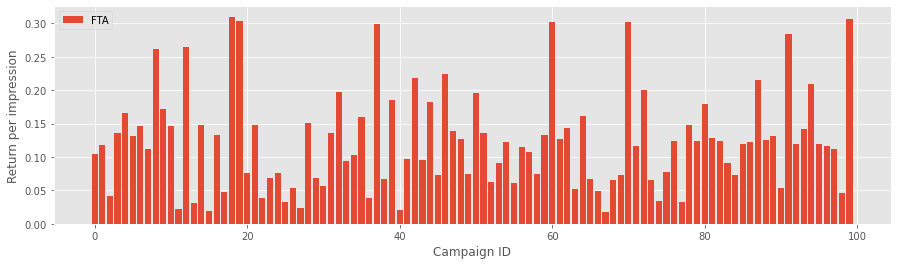

In [15]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [88]:
df6['linear']=0
df6.shape

(626202, 32)

In [90]:

def Linear_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    df_converted['linear'] = df_converted.conversion / (df_converted.click_nb).astype(float)
    
    def linear_attr_by_campaign(df_conv):
        counters = np.zeros(n_campaigns)
        for idx in range(0,len(df_conv)):
            campaign_id = np.argmax(df_conv.iloc[idx, 26])
            counters[campaign_id] = counters[campaign_id] + df_conv.iloc[idx, 31]
        
        return counters
    
    campaign_conversions = linear_attr_by_campaign(df_converted)
    
    return campaign_conversions / campaign_impressions
    
linear_a = Linear_attribution(df6)
linear_a

<ipython-input-90-4529b276f33f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted['linear'] = df_converted.conversion / (df_converted.click_nb).astype(float)


array([0.03355227, 0.14178384, 0.03522036, 0.10262029, 0.23576678,
       0.08895948, 0.02505576, 0.08550609, 0.09581001, 0.06846773,
       0.0970402 , 0.26774987, 0.09802565, 0.06628457, 0.15078726,
       0.0837027 , 0.03138631, 0.1670814 , 0.06651181, 0.12954282,
       0.09124317, 0.06903876, 0.09727199, 0.0894985 , 0.08993701,
       0.22157599, 0.04849575, 0.0553186 , 0.15599193, 0.10309298,
       0.04419777, 0.15845785, 0.0599837 , 0.07444084, 0.15242634,
       0.08732031, 0.1472132 , 0.21314114, 0.13193133, 0.19500729,
       0.0242674 , 0.01292538, 0.25609166, 0.05823153, 0.0752522 ,
       0.15018305, 0.02378303, 0.03499129, 0.03416189, 0.0760034 ,
       0.08362015, 0.190235  , 0.1256696 , 0.15373713, 0.12803681,
       0.1445517 , 0.16736383, 0.16026244, 0.12995004, 0.08302141,
       0.09583859, 0.07094347, 0.32101397, 0.08712625, 0.2994172 ,
       0.03317184, 0.08756055, 0.16514228, 0.11473251, 0.05533722,
       0.04332542, 0.05844543, 0.13989801, 0.04818137, 0.12370

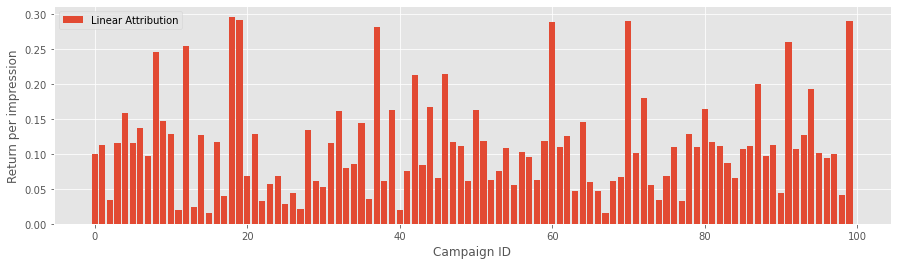

In [91]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(linear_a[campaign_idx])), linear_a[campaign_idx], label='Linear Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [99]:
df6['U_Shape']=0
df6.shape

(626202, 32)

In [101]:
df6.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'U_Shape',
       'conversion_day', 'day', 'TimeDecay_diff', 'linear'],
      dtype='object')

In [98]:
def UShape_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    def UShape_Attr_Value(df_converted):
        default_att = 0.5
        extreme_touch_att = 0.4
        intermed_att = 0.2
        for i in range(0,len(df_converted)):
            if(df_converted.iloc[i,9] == 2):
                df_converted.iloc[i,27]=0.5
            else:
                if(df_converted.iloc[i,9]  == df_converted.iloc[i,9] - 1 or df_converted.iloc[i,8]  ==0):
                    df_converted.iloc[i,27]=0.4
                else:
                    df_converted.iloc[i,27]= 0.2/(df_converted.iloc[i,9] -2)
        return (df_converted)
    
    
    
    def UShape_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(0,len(df_converted)):
            campaign_id = np.argmax(df_conv.iloc[idx, 26])
            counters[campaign_id] = counters[campaign_id] + df_conv.iloc[idx, 27]
            return counters
    
    
    df_converted = UShape_Attr_Value(df_converted) 
    
    campaign_conversions = UShape_by_campaign(df_converted)   
        
    return campaign_conversions / campaign_impressions
UShape_attr = UShape_attribution(df6)
UShape_attr

C:\Users\yashk\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


KeyboardInterrupt: 

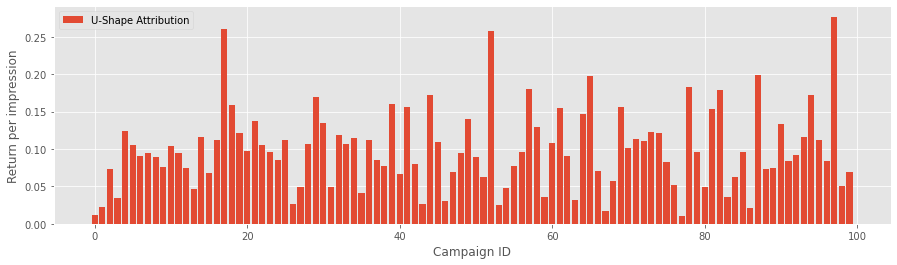

In [126]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(UShape_attr[campaign_idx])), UShape_attr[campaign_idx], label='U-Shape Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [62]:
df6['conversion_day'] = np.floor(df6.conversion_timestamp / 86400.).astype(int)
df6['day'] = np.floor(df6.timestamp / 86400.).astype(int)
df6['TimeDecay_diff']=df6['conversion_day']-df6['day']
df6['TimeDecay_diff']=pow(2,-(df6['TimeDecay_diff']/7))
#pow(2, -(rel_pos/7))
#del df6['TimeDecay']
df6.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'U_Shape',
       'conversion_day', 'day', 'TimeDecay_diff'],
      dtype='object')

In [63]:
def TimeDecay_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        #print('here 1')
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    def calc_attribution(conversion_day,click_day):
        rel_pos =  conversion_day - click_day
        attribution = pow(2, -(rel_pos/7))   
        return attribution
    
    def TimeDecay_Attr_Value(df_converted):
        df_converted['TimeDecay'] = df_converted.apply(lambda val: calc_attribution(val.conversion_day,val.day),axis=1)
        return df_converted
        

    def TimeDecay_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx, 26])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx, 30]
        return counters
    
    
    campaign_conversions = TimeDecay_by_campaign(df_converted)   
        
    return campaign_conversions / campaign_impressions
    
TimeDecay_attr = TimeDecay_attribution(df6)
TimeDecay_attr

array([0.09621272, 0.33960564, 0.07973147, 0.24309777, 0.61059944,
       0.27630213, 0.05883804, 0.18221403, 0.20962826, 0.18221515,
       0.21162985, 0.56733238, 0.38326822, 0.13471333, 0.4500326 ,
       0.31124253, 0.08132704, 0.37828817, 0.13320661, 0.30847652,
       0.17244831, 0.19117111, 0.19065609, 0.17319695, 0.22049361,
       0.37956242, 0.07879104, 0.15456894, 0.32809077, 0.19388062,
       0.10459909, 0.364774  , 0.12729391, 0.16314305, 0.54722964,
       0.20709907, 0.29341106, 0.48141561, 0.23831595, 0.3405414 ,
       0.04842548, 0.03276116, 0.53603214, 0.11197087, 0.1993188 ,
       0.34884614, 0.04791379, 0.07448167, 0.04951445, 0.13410558,
       0.21246376, 0.35999873, 0.28615331, 0.28998229, 0.21121246,
       0.44575232, 0.32279914, 0.35269666, 0.26209726, 0.16776947,
       0.22775137, 0.21282308, 0.56884714, 0.14553266, 0.53144319,
       0.10684783, 0.212117  , 0.2854936 , 0.4023063 , 0.09318651,
       0.08453413, 0.15935982, 0.37412119, 0.10661528, 0.28310

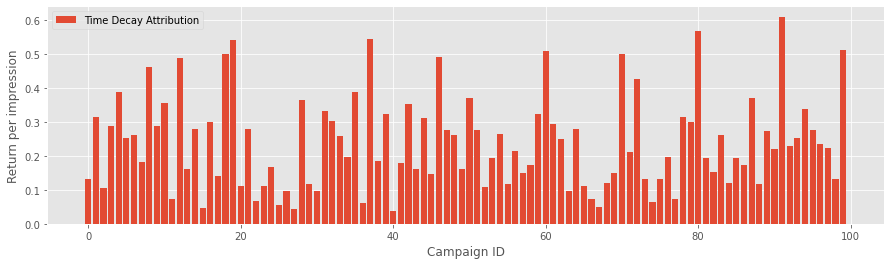

In [64]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(TimeDecay_attr[campaign_idx])), TimeDecay_attr[campaign_idx], label='Time Decay Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [69]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

In [67]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [70]:
pitches = [1.0]
attributions = [lta, TimeDecay_attr, fta,linear_a]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))

0 0 : 305
0 1 : 265
0 2 : 305
0 3 : 317


In [268]:
df6.shape

(718696, 30)